In [34]:
import numpy as np
import matplotlib.pyplot as plt
import random

from numba import jit

In [35]:
def initial_system_config(N):
    # Define a configuração inicial do sistema
    # S recebe valores aleatórios -1 ou 1
    S = np.random.randint(0,2,N)
    S = 2 * S - 1
    return S

In [36]:
def expos(beta):
    ex = np.zeros(5,dtype=np.float32)
    ex[0]=np.exp(8.0*beta)
    ex[1]=np.exp(4.0*beta)
    ex[2]=1.0
    ex[3]=np.exp(-4.0*beta)
    ex[4]=np.exp(-8.0*beta)
    return ex

In [37]:
@jit(nopython=True)
def vizinhos(N):
    # Define a tabela de vizinhos
    L=int(np.sqrt(N))
    viz = np.zeros((N,4),dtype=np.int16)
    for k in range(N):
        viz[k,0]=k+1
        if (k+1) % L == 0:
            viz[k,0] = k+1-L
        viz[k,1] = k+L
        if k > (N-L-1):
            viz[k,1] = k+L-N
        viz[k,2] = k-1
        if (k % L == 0):
            viz[k,2] = k+L-1
        viz[k,3] = k-L
        if k < L:
            viz[k,3] = k+N-L
    return viz

In [38]:
@jit(nopython=True)
def energy(N, viz, S):
    E = 0.0
    for i in range(N):
        h = S[viz[i,0]] + S[viz[i,1]]
        E += -S[i]*h
    return E

In [39]:
def metroplis_ising(N, T, mc_steps):    
# Passos gerais do algoritmo
    beta = 1/T
    ex = expos(beta)
    S = initial_system_config(N)
    energy_system = []
    viz = vizinhos(N)
    
    for _ in range(mc_steps):
        for spin in range(N):
            h = S[viz[spin,0]] + S[viz[spin,1]] + S[viz[spin,2]] + S[viz[spin,3]] # soma dos vizinhos
            de = int(S[spin] * h * 0.5 + 2)
            if random.random() < ex[de]:  # random.random gera um número aleatório entre 0 e 1
                S[spin] = -S[spin]
        energy_system.append(energy(N, viz, S))    
    
    return energy_system

# Temperatura está em unidades de j/kB, onde kb é a constante de Boltzmann

In [40]:
def _plot(values, mc_steps):
    for value in values:
        plt.plot(mc_steps, value)

    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Energy')
    plt.show()

In [41]:
def plot_random_systems_energy(systems, mc_steps=1000):
    mc_steps = np.arange(0, mc_steps, 1)
    _plot(systems, mc_steps)

In [42]:
def generate_systems(N_range, T_range, n_systems=10,  mc_steps=1000):
    systems = []
    # T = np.random.uniform(T_range[0], T_range[1])
    # N = np.random.randint(N_range[0], N_range[1]) ** 2
    N = 1024
    T = 1.5
    for _ in range(n_systems):
        systems.append(metroplis_ising(N, T, mc_steps))
    return systems

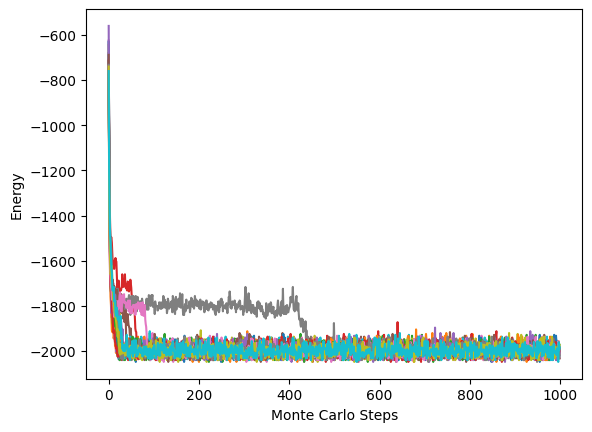

In [43]:
systems = generate_systems([20, 100], [0.4, 3], 20)
plot_random_systems_energy(systems)

In [44]:
"""import numpy as np
import matplotlib.pyplot as plt
import random

# Definição de parâmetros
L = 1024      # Tamanho da rede
T = 1.5     # Temperatura
nsteps = 1000  # Número de passos Monte Carlo
nruns = 20      # Número de simulações independentes

# Função para calcular a energia do sistema
def calc_energy(spin_matrix):
    energy = 0.0
    for i in range(L):
        for j in range(L):
            s = spin_matrix[i,j]
            nb = spin_matrix[(i+1)%L,j] + spin_matrix[i,(j+1)%L] + \
                 spin_matrix[(i-1)%L,j] + spin_matrix[i,(j-1)%L]
            energy += -s*nb
    return energy/2.0

# Função para calcular a magnetização do sistema
def calc_mag(spin_matrix):
    return np.sum(spin_matrix)

# Inicialização da rede
spin_matrix = np.ones((L,L))
for i in range(L):
    for j in range(L):
        if random.random() < 0.5:
            spin_matrix[i,j] = -1.0

# Loop sobre as simulações independentes
for run in range(nruns):
    # Loop sobre os passos Monte Carlo
    energies = []
    for step in range(nsteps):
        # Escolhe um spin aleatório
        i, j = random.randint(0, L-1), random.randint(0, L-1)
        # Calcula a energia antes e depois de inverter o spin
        spin_matrix[i,j] *= -1.0
        dE = -2.0*calc_energy(spin_matrix)
        # Aceita ou rejeita a mudança com probabilidade de Boltzmann
        if random.random() < np.exp(-dE/T):
            # Mudança aceita
            pass
        else:
            # Mudança rejeitada
            spin_matrix[i,j] *= -1.0
        energies.append(calc_energy(spin_matrix))
        
    # Plota a energia por passo Monte Carlo
    plt.plot(range(1000), energies)
    plt.xlabel('Passo Monte Carlo')
    plt.ylabel('Energia')
plt.show()"""


"import numpy as np\nimport matplotlib.pyplot as plt\nimport random\n\n# Definição de parâmetros\nL = 1024      # Tamanho da rede\nT = 1.5     # Temperatura\nnsteps = 1000  # Número de passos Monte Carlo\nnruns = 20      # Número de simulações independentes\n\n# Função para calcular a energia do sistema\ndef calc_energy(spin_matrix):\n    energy = 0.0\n    for i in range(L):\n        for j in range(L):\n            s = spin_matrix[i,j]\n            nb = spin_matrix[(i+1)%L,j] + spin_matrix[i,(j+1)%L] +                  spin_matrix[(i-1)%L,j] + spin_matrix[i,(j-1)%L]\n            energy += -s*nb\n    return energy/2.0\n\n# Função para calcular a magnetização do sistema\ndef calc_mag(spin_matrix):\n    return np.sum(spin_matrix)\n\n# Inicialização da rede\nspin_matrix = np.ones((L,L))\nfor i in range(L):\n    for j in range(L):\n        if random.random() < 0.5:\n            spin_matrix[i,j] = -1.0\n\n# Loop sobre as simulações independentes\nfor run in range(nruns):\n    # Loop sobre os